# Homework 2 - eCommerce analytics

*Authors:*
- _Tansel Simsek_
- _Andrea Carella_
- _Adrienn Timea Aszalos_

Date: 08.11.2020


## Introduction to the homework

<font size="2">E-commerce, also known as electronic commerce or internet commerce, refers to the buying and selling of goods or services using the internet, and the transfer of money and data to execute these transactions. The first e-commerce implementations date back to the 1990s and since then, millions of people every day visit some e-commerce sites to look for some product or service and, eventually, to purchase it.

You have been hired as a data scientist from a big multi-category online store. You and your team have been required to perform an analysis of the customer behavior in the store. Each row in the dataset represents an event, which catches different interactions (views, a product added/removed to/from the cart, purchases) of customers with your e-commerce. All events are related to products and users.

Your goal is to answer some research questions (RQs) that may help us discover and interpret meaningful patterns in data and eventually increase the number of sales.</font>

## Libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc # Garbage Collector
from collections import OrderedDict 

## Importing datasets

<font size="3">**NOTE!!!** 
    The _**category_code**_  and _**brand**_ columns of the dataset may have missing values.</font>

In [103]:
# Importing the file 2019-Oct.csv and converting the values of the column "event_time" from string to type datetime64

dataset = pd.read_csv('./data/2019-Oct.csv', 
                      header='infer', 
                      parse_dates=['event_time'],
                     date_parser=pd.to_datetime, nrows=1000)

# Using this method in order to force the system to try to reclaim the maximum amount of available memory
gc.collect()

22

In [104]:
# Importing the file 2019-Nov.csv and converting the values of the column "event_time" from string to timestamp

dataset_nov = pd.read_csv('./data/2019-Nov.csv', 
                      header='infer', 
                      parse_dates=['event_time'],
                     date_parser=pd.to_datetime, nrows=1000)

# Using this method in order to force the system to try to reclaim the maximum amount of available memory
gc.collect()

0

In [105]:
# Merging the two datasets into one single dataset and storing the final data into an existing variable in order 
# to use as little memory as possible
dataset = dataset.append(dataset_nov).reset_index()

# Deleting the unused variable in order to free memory space
del dataset_nov

# Using this method in order to force the system to try to reclaim the maximum amount of available memory
gc.collect()

20

In [106]:
# Storing the data into a pickle file in order to procees it more rapidly instead of processing the two csv files each time 
# we start the session in Jupiter
dataset.to_pickle("data/mergedata")

In [107]:
dataset = pd.read_pickle("data/mergedata")

## Let's visualize and know our dataset

Viewing the structure of the dataset

In [9]:
dataset.head()

,index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


The columns of our dataset are the following:
- _event_time:_ Time when event happened at (in UTC).
- _event_type:_
    
    Events can be:

    - view - a user viewed a product
    - cart - a user added a product to shopping cart
    - removefromcart - a user removed a product from shopping cart
    - purchase - a user purchased a product

    Typical funnel: view => cart => purchase.
    

- _product_id:_ ID of a product
- _category_id:_ Product's category ID
- _category_code:_ Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.
- _brand:_ Downcased string of brand name. Can be missed. 
- _price:_ Float price of a product. Present.
- _user_id:_ Permanent user ID.
- _user_session:_ Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.

**NOTE!!!** 
- The columns:
    - **_brand_**,
    - _**category_code**_ may **contain missing values**
- The value **_removefromcart_** of the column *event_type* **is missing**.

In [11]:
dataset.columns

Index(['index', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [12]:
print('The dataset is composed of ' + str(dataset.shape[0]) + ' rows and ' + str(dataset.shape[1]) + ' columns.')

The dataset is composed of 2400000 rows and 10 columns.


## Generating a descriptive statistics about the dataframe:

In [13]:
dataset.describe(datetime_is_numeric=True, include='all')

,index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,2.400000e+06,2400000,2400000,2.400000e+06,2.400000e+06,1632230,2041636,2.400000e+06,2.400000e+06,2400000
unique,NaN,NaN,3,NaN,NaN,126,2984,NaN,NaN,537771
top,NaN,NaN,view,NaN,NaN,electronics.smartphone,samsung,NaN,NaN,4488e77a-9901-4c4b-b162-47a224ceab51
freq,NaN,NaN,2328239,NaN,NaN,647537,290497,NaN,NaN,504
mean,5.999995e+05,2019-10-16 23:03:14.677083392+00:00,NaN,1.062967e+07,2.057043e+18,NaN,NaN,2.947177e+02,5.332339e+08,NaN
min,0.000000e+00,2019-10-01 00:00:00+00:00,NaN,1.000978e+06,2.053014e+18,NaN,NaN,0.000000e+00,2.449511e+08,NaN
25%,2.999998e+05,2019-10-01 11:54:56+00:00,NaN,1.005158e+06,2.053014e+18,NaN,NaN,6.687000e+01,5.158089e+08,NaN
50%,5.999995e+05,2019-10-16 22:03:32.500000+00:00,NaN,5.100450e+06,2.053014e+18,NaN,NaN,1.670600e+02,5.290694e+08,NaN
75%,8.999992e+05,2019-11-01 10:36:49+00:00,NaN,1.650001e+07,2.053014e+18,NaN,NaN,3.621000e+02,5.507270e+08,NaN
max,1.199999e+06,2019-11-01 17:29:23+00:00,NaN,6.170001e+07,2.180737e+18,NaN,NaN,2.574070e+03,5.665404e+08,NaN


## Managing missing data values

In [14]:
print('There are ' + str(dataset['brand'].isnull().sum()) + ' rows that present missing values in the column brand.')

There are 358364 rows that present missing values in the column brand.


In [15]:
print('There are ' + str(dataset['category_code'].isnull().sum()) + ' rows that present missing values in the column category_code.')

There are 767770 rows that present missing values in the column category_code.


In [16]:
print('The total number of the rows containing missing values is: ' + str(dataset.isnull().any(axis=1).sum()) + '.')

The total number of the rows containing missing values is: 905336.


In [17]:
print('The percentage of missing value in the original dataset is: ' + str(round(dataset.isnull().any(axis=1).sum()/len(dataset),2)) + '%.')

The percentage of missing value in the original dataset is: 0.38%.


**Why did we chose to maintain the NaN values**

Since the less populated values are the ones of the attributes *category_code* and *brand* we opt to maintain the missing values (NaN) without replacing them or filling them with other values, because it doesn't make much sense to impute values for a category code or/and a brand name.

If we would have performed machine learning techniques then in that case we would have filled in the missing values.
Also we excluded the removal of the missing data because the percentage of it was very high (see cell above).

## Research questions

### [RQ1] 

**INTRO**

A marketing funnel describes your customer’s journey with your e-commerce. It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond. Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. 

### [RQ1.0] 
Which is the rate of complete funnels?


In [19]:
gc.collect()

# Group dataset by product_id, user_session and event_type and count the occurrences of each event type
completeFunnel = dataset.groupby(['product_id', 'user_session', 'event_type']).event_type.count()

# Convert obtained GroupBy Series into a Dataframe in order to rename the name of the column 
# containing the occurrences for each event type
completeFunnel = pd.DataFrame(completeFunnel).rename(columns={'event_type':'count'}).reset_index()

gc.collect()

# Group dataset by product_id and user_session and count the occurrences of each user session 
completeFunnel = completeFunnel.groupby(['product_id','user_session']).user_session.count()

# Convert obtained GroupBy Series into a Dataframe in order to rename the name of the column 
# containing the occurrences for each user session
completeFunnel = pd.DataFrame(completeFunnel).rename(columns={'user_session':'count'}).reset_index()

gc.collect()

# Total number of rows containing the occurrences of each user session
N = int(completeFunnel.shape[0])

# Number of all the rowss containing all the three steps (view, cart, purchase) per session
n = completeFunnel[completeFunnel['count'] == 3].shape[0]

# Calculate the rate of complete funnels 
completeFunnelRate = round(n*100/N)

print("The complete funnel rate is:", str(completeFunnelRate) + '%')

# Delete variable to free RAM
del completeFunnel, N, n

The complete funnel rate is: 1%


### [RQ1.1]

What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

From the plot we can deduce the following informations:

1. The most repetead operation is: view.
2. The average number of cart operations per session is: 0.06
3. The average number of purchase operations per session is: 0.07
4. The average number of view operations per session is: 4.33
5. The average number of removefromcart operations per session is: 0


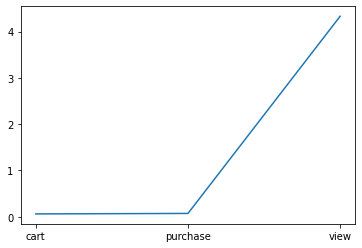

In [22]:
gc.collect()
# Grouping the data by the event types and counting the number of occurrences for each event:
totalOperationsPerEventType = dataset.groupby('event_type').event_type.count()

# Converting the dataset into an array and dividing each element of the array by the total unique numbers of sessions
# in order to obtain the average number of operations per event type
averageNumberOfOperationsPerSession = totalOperationsPerEventType.to_numpy()/dataset.user_session.nunique()

# Getting the unique names of the event types 
eventTypes = sorted(dataset.event_type.unique())

# Plotting the average number of times users perform each operation (view/removefromchart etc etc)
plt.plot(eventTypes,averageNumberOfOperationsPerSession)

print("From the plot we can deduce the following informations:" + '\n')
print("1. The most repetead operation is:", str(eventTypes[len(eventTypes)-1]) + ".")
print("2. The average number of cart operations per session is: " + str(round(averageNumberOfOperationsPerSession[0],2)))
print("3. The average number of purchase operations per session is: " + str(round(averageNumberOfOperationsPerSession[1],2)))
print("4. The average number of view operations per session is: " + str(round(averageNumberOfOperationsPerSession[2],2)))
print("5. The average number of removefromcart operations per session is: " + str(0))

del totalOperationsPerEventType, averageNumberOfOperationsPerSession, eventTypes

### [RQ6.1] 
The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store? Find the overall conversion rate of your store.

In [37]:
gc.collect()
# The following table shows how many times a product has been purchased.
purchasedProducts = pd.DataFrame(dataset[dataset.event_type == 'purchase'].groupby('product_id').product_id.count()).rename(columns={'product_id':'count purchases'}).reset_index()

# The following table shows how many times a product has been viewed.
viewedProducts = pd.DataFrame(dataset[dataset.event_type == 'view'].groupby('product_id').product_id.count()).rename(columns={'product_id':'count views'}).reset_index()

# Join on the two tables
mergedTable = purchasedProducts.join(viewedProducts.set_index('product_id'), on = 'product_id')

# Add a new column to the table and calculate the conversion rate for each product
mergedTable['conversion rate'] = mergedTable['count purchases']/mergedTable['count views']

# Calculate the overall conversion rate of the store
print('The overall conversion rate of the store is equal to: ' + str(round(mergedTable['conversion rate'].mean(),2)) + '%.')

del purchasedProducts, viewedProducts, mergedTable

The overall conversion rate of the store is equal to: 0.07%.


### [RQ6.2] 
Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

In [35]:
# The following table shows how many times a product has been purchased for each category
gc.collect()
purchasedProducts = pd.DataFrame(dataset[dataset.event_type == 'purchase'].groupby('category_id').product_id.count()).rename(columns={'product_id':'count_purchases'}).reset_index()

# The following table shows how many times a product has been viewed for each category
viewedProducts = pd.DataFrame(dataset[dataset.event_type == 'view'].groupby('category_id').product_id.count()).rename(columns={'product_id':'count_views'}).reset_index()

# Join on the two tables
mergedTable = purchasedProducts.join(viewedProducts.set_index('category_id'), on = 'category_id')
del purchasedProducts, viewedProducts

# Add a new column to the table and calculate the conversion rate for each product category
mergedTable['conversion_rate'] = mergedTable['count_purchases']/mergedTable['count_views']
pd.options.display.float_format = '{:,.2f}'.format
mergedTable = mergedTable.sort_values(by = 'conversion_rate', ascending = False)
print('The number of purchases for each product category and the conversion rate for each product category in decreasing order can be viewed in the table below:')
mergedTable

The number of purchases for each product category and the conversion rate for each product category in decreasing order can be viewed in the table below:


,category_id,count_purchases,count_views,conversion_rate
419,2149484852091552186,4,53,0.08
319,2077453854185620383,8,127,0.06
369,2110937219005940617,1,19,0.05
138,2053013558643393109,4,91,0.04
431,2172371118332051820,2,49,0.04
...,...,...,...,...
398,2135658542386905834,4,3015,0.00
308,2070005009256284935,1,894,0.00
403,2137704926053138958,1,1062,0.00
366,2110187395394568257,1,1156,0.00


### [RQ4.1] 
How much does each brand earn per month? Write a function that given the name of a brand in input returns, for each month, its profit. 

In [58]:
gc.collect()

# The function returns, for each month, the profit of the given brand
def getProfitsPerMonth(brandName):
    
    # Select only the rows with the given brand name
    brandedTable = pd.DataFrame(dataset[dataset.brand == brandName])

    # Select only the rows with the selled item and calculate the total profit for each month
    brandedTable = pd.DataFrame(brandedTable[dataset.event_type == 'purchase'].groupby(dataset.event_time.dt.month).price.sum()).rename(columns={'price':'profit'}).reset_index()

    # Renaming the column for a better understanding of the output
    brandedTable.columns = ['month','profit']

    return brandedTable

In [62]:
# Input the name of the brand
print("Please enter the name of the brand to return it's profit for each month.")
brandName = input()
brandedTable = getProfitsPerMonth(brandName)

# Outputting the profits of the given brand for each month
print("The profit for the brand " + brandName + " for each month is the following:")
brandedTable

Please enter the name of the brand to return it's profit for each month.
apple


<ipython-input-58-0f2ed8e1b33c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  brandedTable = pd.DataFrame(brandedTable[dataset.event_type == 'purchase'].groupby(dataset.event_time.dt.month).price.sum()).rename(columns={'price':'profit'}).reset_index()


The profit for the brand apple for each month is the following:


,month,profit
0,10,"3,066,379.88"
1,11,"3,000,326.42"


### [RQ4.2] 
Is the average price of products of different brands significantly different?

In [14]:
gc.collect()
 
pd.options.display.float_format = '{:,.2f}'.format # Formatting the float values

# Function that returns the mean price for each product category
def getMeanPriceOfOtherBrands(brandName):
    return pd.DataFrame(dataset[dataset.brand != brandName].groupby([dataset.brand]).price.mean()).rename(columns={'price':'mean_price'}).reset_index().sort_values(by = 'mean_price', ascending = False)

meanPriceOfBrands = getMeanPriceOfOtherBrands(brandName)
print('The average price of products of different brands vary very much as we can observe from the table below:')
meanPriceOfBrands

The average price of products of different brands vary very much as we can observe from the table below:


,brand,mean_price
2088,pinarello,"2,555.09"
972,fondital,"2,310.07"
2178,rado,"2,157.86"
568,climadiff,"1,999.03"
2408,shua,"1,911.64"
...,...,...
1442,kleancolor,1.67
951,fitokosmetik,1.46
1882,naturalist,1.42
593,compliment,1.42


### [RQ4.3]
Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing bothe the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

In [71]:
gc.collect()

# Select only the rows with the selled item and calculate the total profit for each month
totalProfitsPerMonth = dataset[dataset.event_type == 'purchase'].groupby([dataset.brand, dataset.event_time.dt.month]).price.sum()

# Renaming column of profits and sorting it's values
totalProfitsPerMonth = pd.DataFrame(totalProfitsPerMonth).rename(columns = {'price':'profits'}).reset_index().sort_values(by = 'profits', ascending = False)

# Renaming column of month 
totalProfitsPerMonth.rename(columns = {'event_time':'month'})

totalProfitsPerMonth


,brand,event_time,profits
64,apple,10,"3,066,379.88"
65,apple,11,"3,000,326.42"
1116,samsung,11,"1,216,831.03"
1115,samsung,10,"1,202,063.67"
1364,xiaomi,11,"232,491.31"
...,...,...,...
1250,topface,10,3.60
1081,rimmellondon,11,3.54
782,luxvisage,11,3.35
428,evamosaic,11,2.72


In [ ]:
# List of unique brands
arrOfBrands = dataset['brand'].dropna().unique().tolist()

for index, row in arrOfBrandsOfBrands

In [145]:
gc.collect()

# List of unique brands
arrOfBrands = dataset['brand'].dropna().unique().tolist()

# Dataframe storing all the brands and their losses between October and November
topBrands = pd.DataFrame(columns = ['brand', 'losses'])

# Iterate per each brand of the dataset
for br in arrOfBrands:
    
    # Call the function getProfitsPerMonth which will return a DataFrame containing the earnings of the brand for each month
    profitsPerMonthOfABrand = getProfitsPerMonth(br)
    
    # Create dictionary for the brand
    dicOfProfitsPerMonth = OrderedDict()
    
    # Iterate for each row of the returned dataframe which contains the earnings of the brand for each month
    for index, row in profitsPerMonthOfABrand.iterrows():
        month = int(row['month'])
        profit = round(row['profit'], 2)
        dicOfProfitsPerMonth[month] = profit
        
    lossBetweenTwoMonths = 0 
    
    # Controlling of the brand has profits in October and November
    if len(dicOfProfitsPerMonth) == 2:
        lossBetweenTwoMonths = round(abs(dicOfProfitsPerMonth[11] - dicOfProfitsPerMonth[10]) / dicOfProfitsPerMonth[10], 2)
    # The brand has registered profits only in one of the two months
    else:
        lossBetweenTwoMonths = 100.00
    
    # Creating a temporary dataframe with one row contaning the name of the brand and the percentage loss
    #tempDf = pd.DataFrame([[br, lossBetweenTwoMonths]], columns = ['brand', 'losses'])
    new_row = {'brand':br, 'losses':lossBetweenTwoMonths}
    
    # Appending the temporary dataframe to the dataframe contaning all brands and their losses in percentage
     # first row of data frame
    topBrands.append(new_row, ignore_index=True)
    #print(topBrands)
    
topBrands


    

<ipython-input-58-0f2ed8e1b33c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  brandedTable = pd.DataFrame(brandedTable[dataset.event_type == 'purchase'].groupby(dataset.event_time.dt.month).price.sum()).rename(columns={'price':'profit'}).reset_index()


{'brand': 'shiseido', 'losses': 100.0}
{'brand': 'aqua', 'losses': 100.0}
{'brand': 'lenovo', 'losses': 100.0}
{'brand': 'apple', 'losses': 100.0}
{'brand': 'pulser', 'losses': 100.0}
{'brand': 'creed', 'losses': 100.0}
{'brand': 'luminarc', 'losses': 100.0}
{'brand': 'baden', 'losses': 100.0}
{'brand': 'huawei', 'losses': 100.0}
{'brand': 'elenberg', 'losses': 100.0}
{'brand': 'samsung', 'losses': 3.72}
{'brand': 'haier', 'losses': 100.0}
{'brand': 'brw', 'losses': 100.0}
{'brand': 'bosch', 'losses': 100.0}
{'brand': 'hp', 'losses': 100.0}
{'brand': 'jbl', 'losses': 100.0}
{'brand': 'xiaomi', 'losses': 6.18}
{'brand': 'midea', 'losses': 100.0}
{'brand': 'ariston', 'losses': 100.0}
{'brand': 'redmond', 'losses': 100.0}
{'brand': 'gran-stone', 'losses': 100.0}
{'brand': 'maxwell', 'losses': 100.0}
{'brand': 'respect', 'losses': 100.0}
{'brand': 'dauscher', 'losses': 100.0}
{'brand': 'atlant', 'losses': 100.0}
{'brand': 'burgerschuhe', 'losses': 100.0}
{'brand': 'timberk', 'losses': 100.

{'brand': 'smile', 'losses': 100.0}
{'brand': 'continental', 'losses': 100.0}
{'brand': 'inhouse', 'losses': 100.0}
{'brand': 'westa', 'losses': 100.0}
{'brand': 'nikon', 'losses': 100.0}
{'brand': 'iwalk', 'losses': 100.0}
{'brand': 'novline', 'losses': 100.0}
{'brand': 'leatherman', 'losses': 100.0}
{'brand': 'toshiba', 'losses': 100.0}
{'brand': 'lacoste', 'losses': 100.0}
{'brand': 'maxxis', 'losses': 100.0}
{'brand': 'phoenix', 'losses': 100.0}
{'brand': 'graphite', 'losses': 100.0}
{'brand': 'gezatone', 'losses': 100.0}
{'brand': 'rooman', 'losses': 100.0}
{'brand': 'inoi', 'losses': 100.0}
{'brand': 'suunto', 'losses': 100.0}
{'brand': 'whirlpool', 'losses': 100.0}
{'brand': 'dion', 'losses': 100.0}
{'brand': 'gerber', 'losses': 100.0}
{'brand': 'kormoran', 'losses': 100.0}
{'brand': 'artmusical', 'losses': 100.0}
{'brand': 'orient', 'losses': 100.0}
{'brand': 'joyroad', 'losses': 100.0}
{'brand': 'stendmebel', 'losses': 100.0}
{'brand': 'machaon', 'losses': 100.0}
{'brand': 'tp

,brand,losses
